# 🧠 Explainable Vision Transformer for Image Classification

## Data preprocessing

In [31]:
import numpy as np
from datasets import load_dataset
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import CenterCrop,Compose,Normalize,RandomHorizontalFlip,RandomResizedCrop,Resize,ToTensor
from torch.utils.data import DataLoader
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
#%pip install transformers==4.37.2
#%pip install accelerate==0.28.0
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from collections import Counter

### Used dataset: **CIFAR-10**
The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
The dataset is divided into 5 training batches and one test batch, each with 10000 images, and the test batch contains exactly 1000 randomly-selected images from each class.

**I divided the train set in this way**:
* train set: 4/5
* validation set: 1/5

Each data is composed of two fields:
* ['img'] : Image object
* ['label'] : ClassLabel

In [32]:
# I loaded the dataset and i splitted it in train e test 
# later i extracted validation set from train set
def prepare_dataset():
    train_ds, test_ds = load_dataset('cifar10', split=['train','test'])
    splits = train_ds.train_test_split(test_size=0.2, seed=42)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = prepare_dataset()

# print some informations about the dataset CIFAR-10 
print("Training set size:", len(train_ds))
print("Validation set size:", len(val_ds))
print("Test set size:", len(test_ds))

labels = train_ds.features['label'].names
train_label = Counter(example['label'] for example in train_ds)
val_label = Counter(example['label'] for example in val_ds)
test_label = Counter(example['label'] for example in test_ds)


# We print some informations about loaded dataset
print(f"\n{'Class':<6} {'Label':<20} {'Train':<7} {'Val':<7} {'Test':<7}")
print("-" * 50)

for i in range(len(labels)):
    train_count = train_label.get(i, 0)
    val_count = val_label.get(i, 0)
    test_count = test_label.get(i, 0)
    print(f"{i:<6} {labels[i]:<20} {train_count:<7} {val_count:<7} {test_count:<7}")

Training set size: 40000
Validation set size: 10000
Test set size: 10000

Class  Label                Train   Val     Test   
--------------------------------------------------
0      airplane             3989    1011    1000   
1      automobile           4031    969     1000   
2      bird                 3993    1007    1000   
3      cat                  4042    958     1000   
4      deer                 3986    1014    1000   
5      dog                  3979    1021    1000   
6      frog                 3990    1010    1000   
7      horse                3994    1006    1000   
8      ship                 4011    989     1000   
9      truck                3985    1015    1000   


Here, the first image (index 0) of the training set is shown, along with its label.

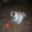

In [33]:
# show image with its label (each data is in the format [img,'label'])
train_ds[0]['label']
id2label = {i: name for i, name in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
train_ds[0]['img']

In [34]:
# print the corresponding label
label_name = id2label[train_ds[0]['label']]
print(f'Label: {label_name}')

Label: dog


To ensure the input image is compatible with ViT, we use the corresponding processor object to preprocess it.

In [35]:
# load the processor to preprocess data
ViTprocessor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

/Users/gallo/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We apply augmentation to the datas:
* ```RandomResizedCrop()```: We crop a random portion of the image and resize it to the specified size.
* ```RandomHorizontalFlip()```: Horizontally flip the image with a default probability of 0.5.
* ```ToTensor()```: We convert the image from a PIL Image to a tensor (ViT input format).
* ```Normalize```:  We normalize the data using the given mean and standard deviation values.

In [36]:
# We load the mean and standard deviation used to pre-train the ViT loaded from hugging face
# We use these values to process CIFAR-10 datas
image_mean, image_std = ViTprocessor.image_mean, ViTprocessor.image_std
size = ViTprocessor.size["height"]

normalize = Normalize(ViTprocessor.image_mean, ViTprocessor.image_std)

_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

# We apply transformations to all dataset
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [37]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [38]:
# We pack the data in the following format:
# pixel values -> tensor
# labels -> tensor
# ready data for the model's training
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

## Model Architecture and Training

We can load two models:
- **Data-efficient Image Transformer (DeiT)** model pre-trained on ImageNet-1k (1 million image and 1000 classes at resolution 224x224), with about 5.5M parameters

- **Google Vision Transformer** pre-trained on ImageNet-21k (14 million image and 21843 classes) with about 86M di parameters

**DeiT** is actually a more efficiently trained Vision Transformer (ViT).

Sources: [DeiT](https://huggingface.co/facebook/deit-tiny-patch16-224), [Google ViT](https://huggingface.co/google/vit-base-patch16-224)

In [39]:
ViTmodel = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', 
                                                     #'facebook/deit-tiny-patch16-224',
                                                     num_labels=10,
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    ignore_mismatched_sizes=True)

# facebook/deit-tiny-patch16-224
## posso usare anche facebook/deit-small-patch16-224 che ha molti più parametri (più training time)

## Specify training arguments

args = TrainingArguments(
    f"finetuned-googlevit/checkpoint-7500",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    logging_dir='logs',
    remove_unused_columns=False,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(
        eval_accuracy=accuracy_score(labels, predictions),
        eval_f1_score=f1_score(labels, predictions, average="weighted")
    )

trainer = Trainer(
    model=ViTmodel,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

#model already trained and saved correctly on 'finetuned-*/'
#trainer.train()


/Users/gallo/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


## Evaluation and Results

In [41]:
trainer = Trainer(
    model=ViTForImageClassification.from_pretrained("finetuned-googlevit/checkpoint-7500"),
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

results = trainer.evaluate(val_ds)
print("\nEvaluation Metrics")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"F1 Score: {results['eval_f1_score']:.4f}")
print(f"Loss: {results['eval_loss']:.4f}")

  0%|          | 0/625 [00:00<?, ?it/s]


Evaluation Metrics
Accuracy: 0.9883
F1 Score: 0.9883
Loss: 0.0388


In [52]:
outputs = trainer.predict(test_ds)
for metric, value in outputs.metrics.items():
    print(f"{metric}: {value:.4f}")

  0%|          | 0/625 [00:00<?, ?it/s]

test_loss: 0.0476
test_eval_accuracy: 0.9857
test_eval_f1_score: 0.9857
test_runtime: 382.5352
test_samples_per_second: 26.1410
test_steps_per_second: 1.6340


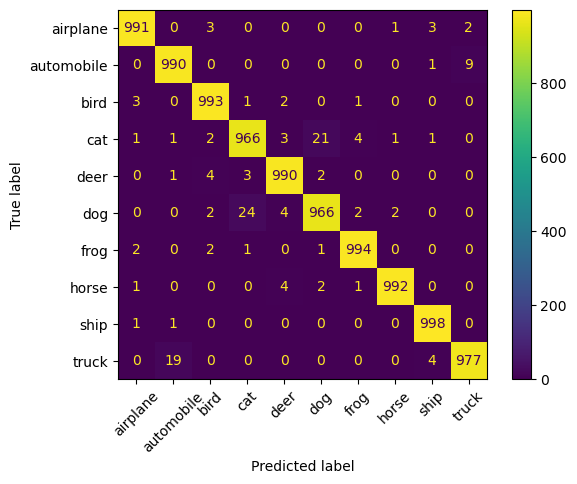

In [53]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## Explainable Visualization 

In [44]:
ID2CLS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

``` show_cam_on_image```: Applies a heatmap overlay to a test image, helping us visualize which regions most influenced the model’s decision.

```print_top_classes(predictions)```: Applies a softmax to the model’s output logits, retrieves the top 10 most probable classes for the input image, and prints each class name alongside its probability percentage.

In [55]:
def show_cam_on_image(img, mask):
    # We display the heatmap on the features that models learn during training
    # to classify the image in the correct way
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# compute the probability of all the classes to be assigned to a test image, thourgh softmax
def print_top_classes(predictions):
    probs = torch.softmax(predictions, dim=-1)
    class_indices = predictions.data.topk(10, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(ID2CLS[cls_idx])
        if len(ID2CLS[cls_idx]) > max_str_len:
            max_str_len = len(ID2CLS[cls_idx])
    # Computing the probability for that image for each class, we have the probabilities in output
    print(f'Probability on all the classes:')
    for cls_idx in class_indices:
        output_string = '\t{}'.format(ID2CLS[cls_idx])
        output_string += ' ' * (max_str_len - len(ID2CLS[cls_idx])) + '\t'
        output_string += 'prob = {:.1f}%'.format(100 * probs[0, cls_idx])
        print(output_string)

```attention_rollout(attention, discard_radio)```: 
**Attention Rollout** is a technique used to visualize **which parts of the image most influenced the Vision Transformer (ViT)’s decision**. It addresses the issue that attention weights in deeper layers often become less interpretable and may lose important information.

The key idea behind attention rollout is to recursively compute the token attentions in each layer of the Transformer by multiplying the attention matrices across layers. This allows the attention signal to be propagated through the entire network, rather than just being visible in the first few layers, and in this way we can see which patches were truly important for the prediction

By using it, only patterns that remain important through to the final layers are highlighted, while patterns that lose their significance as the information processing progresses are excluded.

We also apply a **discard ratio** to filter out the smallest values in the attention matrices, focusing the visualization on the most relevant attention scores.

In [56]:
def attention_rollout(attentions, discard_ratio):
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    #iteration on all attention's level aggregating different attention heads
    for attn in attentions:
        attn_heads_fused = attn[0].mean(0)
        
        if discard_ratio > 0:
            flat = attn_heads_fused.view(-1)
            _, indices = flat.topk(int(flat.size(0) * discard_ratio), largest=False)
            flat[indices] = 0
            attn_heads_fused = flat.view(attn_heads_fused.size())

        attn_heads_fused += torch.eye(attn_heads_fused.size(0)).to(attn_heads_fused.device)
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn_heads_fused, result)
    mask = result[0, 1:]
    return mask

In [57]:
def generate_visualization(pil_image, outputs, logits):

    attentions = outputs.attentions
    probs = torch.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()
    label = ID2CLS.get(pred_class, str(pred_class))

    mask = attention_rollout(attentions, discard_ratio = 0.4)
    num_patches = mask.shape[0]
    size = int(num_patches ** 0.5)
    mask = mask.reshape(1, 1, size, size)

    cam = torch.nn.functional.interpolate(mask, scale_factor=16, mode='bilinear').squeeze().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    image_np = np.array(pil_image.resize((224, 224))).astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(image_np, cam)

    return cam_overlay, label

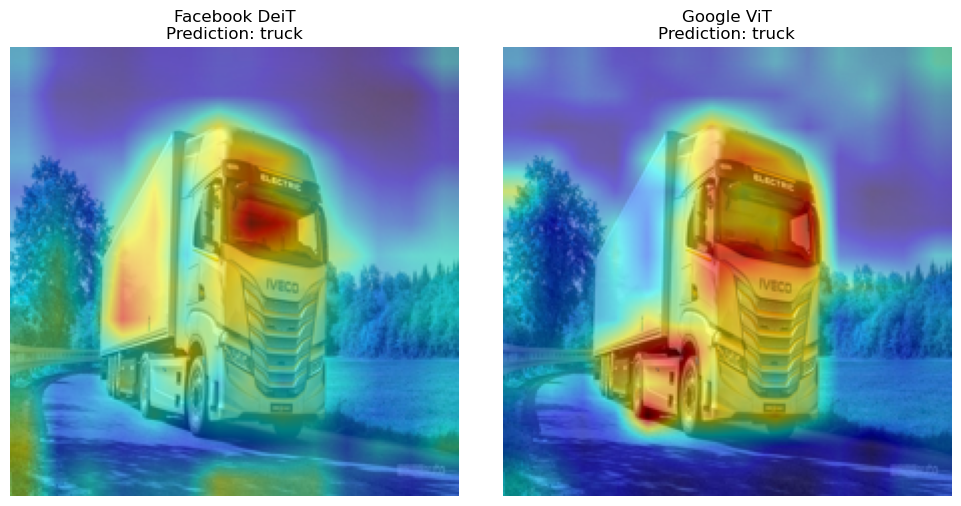


🔎 Top classes for Facebook DeiT:
Probability on all the classes:
	truck     	prob = 99.0%
	dog       	prob = 0.2%
	automobile	prob = 0.2%
	ship      	prob = 0.2%
	horse     	prob = 0.1%
	airplane  	prob = 0.1%
	cat       	prob = 0.1%
	frog      	prob = 0.1%
	deer      	prob = 0.0%
	bird      	prob = 0.0%

🔎 Top classes for Google ViT:
Probability on all the classes:
	truck     	prob = 99.6%
	bird      	prob = 0.1%
	automobile	prob = 0.1%
	ship      	prob = 0.0%
	airplane  	prob = 0.0%
	deer      	prob = 0.0%
	horse     	prob = 0.0%
	dog       	prob = 0.0%
	cat       	prob = 0.0%
	frog      	prob = 0.0%


In [ ]:
models = {
    "Facebook DeiT": "finetuned-facebookdeit/checkpoint-7500",
    "Google ViT": "finetuned-googlevit/checkpoint-7500"
}
file_path = "test_img/cat5.png"
image = Image.open(file_path)
results = {}

for name, model_path in models.items():
    # Carica modello e processor
    model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True)
    processor = ViTImageProcessor.from_pretrained(model_path)
    model.eval()

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits
        predicted_class = predictions.argmax(-1).item()
        label = model.config.id2label[predicted_class]

    vis, _ = generate_visualization(image, outputs, predictions)

    results[name] = {
    "label": label,
    "visualization": vis,
    "logits": predictions
    }

# ---- Visualizzazione affiancata ----
plt.figure(figsize=(10, 5))
for i, (model_name, result) in enumerate(results.items()):
    plt.subplot(1, 2, i+1)
    vis_rgb = cv2.cvtColor(result["visualization"], cv2.COLOR_BGR2RGB)
    plt.imshow(vis_rgb)
    plt.title(f"{model_name}\nPrediction: {result['label']}")
    plt.axis("off")

plt.tight_layout()
plt.show()
for model_name, result in results.items():
    print(f"\n🔎 Top classes for {model_name}:")
    print_top_classes(result["logits"])